# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 7. Рекурентные сети для обработки последовательностей

In [10]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
#from IPython import display
from torchvision.utils import save_image, make_grid
from IPython.display import display, Math, Latex

In [11]:
%%time
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda
CPU times: user 3.85 ms, sys: 28.9 ms, total: 32.8 ms
Wall time: 66.3 ms


### 1. Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции  
<center>$y = \frac{sin(x)}{x} − \frac{x}{10}$</center>
  
При выполнении данного задания структура GAN остается той же, но Вам нужно:  
- Сгенерировать настоящие данные  
- Изменить архитектуру дискриминатора и генератора  
- Без графиков домашку не принимаю

In [ ]:
train_data_length = 8192
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 10 * math.pi * (2 * torch.rand(train_data_length) - 1)
train_data[:, 1] = torch.sin(train_data[:, 0])/train_data[:, 0] - train_data[:, 0]/10
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

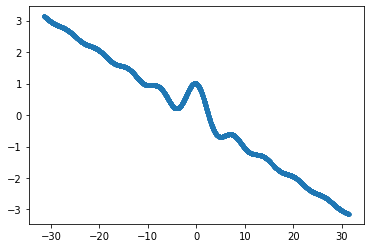

In [ ]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [ ]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [ ]:
lr = 0.001
num_epochs = 20001
loss_function = nn.BCELoss()

In [ ]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
%%time
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 5000 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

CPU times: user 2h 8min 34s, sys: 58.1 s, total: 2h 9min 32s
Wall time: 2h 9min 18s


In [ ]:
latent_space_samples = torch.randn(16384, 2)
generated_samples = generator(latent_space_samples)

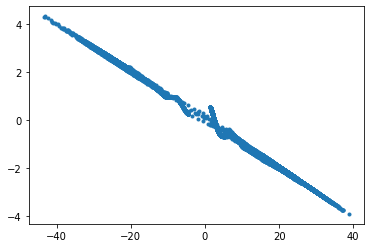

In [ ]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

### 2. (*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как описано в оригинальной статье. И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться официальной статьей от pytorch. 

In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "/content/datasets"

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [ ]:
rescale = lambda x: 2 * x -1

train_dataset = dset.MNIST(
root = '/content/datasets',
train = True,
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               rescale,
                               transforms.Normalize((0.5), (0.5)),
                              ]),
download = True,
)
test_dataset = dset.MNIST(
root = '/content/datasets',
train = False,
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               rescale,
                               transforms.Normalize((0.5), (0.5)),
                              ])
)
print(train_dataset)
print(test_dataset)
print(train_dataset.data.size())
print(test_dataset.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(28, 28))
               ToTensor()
               <function <lambda> at 0x7fc42a184c20>
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/datasets
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(28, 28))
               ToTensor()
               <function <lambda> at 0x7fc42a184c20>
               Normalize(mean=0.5, std=0.5)
           )
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [ ]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True)

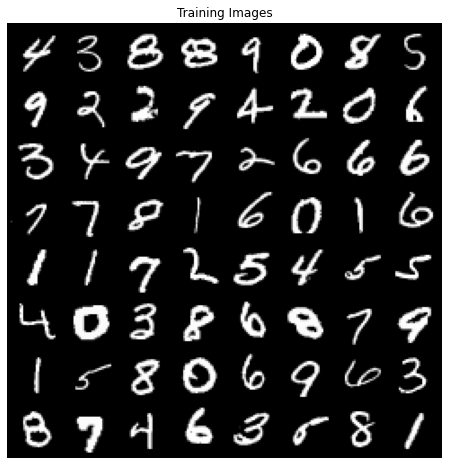

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        """Input: (_, latent_size) noise tensor
            Output: (_, 1, 32, 32) generated image tensor"""
        input = input.view(-1, nz, 1, 1)
        return self.upsample(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 3, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        """Input: (_, 1, 28, 28) image
            Output: (_, 1) classification tensor"""
        input = input.view(-1, 1, 28,28)
        return self.main(input).view(-1)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
rescale = lambda x: 2 * x -1
transform = transforms.Compose([
                    transforms.ToTensor(),
                    rescale
])
class MNISTDS(Dataset):
    def __init__(self, mnist_ds, transform):
        super().__init__()
        self.mnist_ds= mnist_ds
        self.transform = transform
    def __len__(self):
        return len(self.mnist_ds)
    def __getitem__(self, i):
        return self.transform(self.mnist_ds[i][0]), self.mnist_ds[i][1]
ds = MNISTDS(train_dataset, transform)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: ignored

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

###### fully copypasted

In [53]:
import torch
import numpy as np
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, Dataset

In [54]:
DATA = "/content/data/"

In [55]:
%%capture
mnist_ds= torchvision.datasets.MNIST(DATA, download=True)

In [56]:
import torchvision.transforms as transforms

In [57]:
rescale = lambda x: 2 * x -1
transform = transforms.Compose([
                    transforms.ToTensor(),
                    rescale
])

In [58]:
class MNISTDS(Dataset):
    def __init__(self, mnist_ds, transform):
        super().__init__()
        self.mnist_ds= mnist_ds
        self.transform = transform
    def __len__(self):
        return len(self.mnist_ds)
    def __getitem__(self, i):
        return self.transform(self.mnist_ds[i][0]), self.mnist_ds[i][1]

In [59]:
ds = MNISTDS(mnist_ds, transform)

In [60]:
import torch.nn as nn

In [61]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        """latent_size = size of the latent space"""
        super(Generator, self).__init__()

        self.latent_size = latent_size

        #kernel size
        self.kernel_size =4
        #(proportional to the) number of generator filters
        self.ngf = 64

        #takes a latent vector and outputs MNIST-sized image
        #input: (_, nz, 1, 1) latent vector
        self.upsample = nn.Sequential(

                                nn.ConvTranspose2d(self.latent_size, 4 * self.ngf, self.kernel_size,
                                                      stride=1,padding=0,bias=False),
                                nn.BatchNorm2d( 4 * self.ngf),
                                nn.ReLU(),
                                #spatial extent here is set by the kernel: (4,4)

                                #by setting stride=2, we effectively double the output size (up to fiddling
                                #with the boundary conditions..)
                                # Weirdly, increasing the 'padding' arg actually decreases the amount of padding
                                #that's applied to the input. the only reason padding is being used here is to
                                #keep the output shapes at nice multiples of two
                                nn.ConvTranspose2d(4 * self.ngf, 2 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 2 * self.ngf),
                                nn.ReLU(),

                                #( 8,8)
                                nn.ConvTranspose2d(2 * self.ngf, 1 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 1 * self.ngf),
                                nn.ReLU(),
                                #(16,16)
                                #here I'm increasing the padding to bring the output size to (28,28)
                                #for MNIST
                                nn.ConvTranspose2d(self.ngf, 1, self.kernel_size,
                                                      stride=2,padding=3, bias=False),
                                nn.Tanh(),
                                #(32,32)


                                )

    def forward(self, z):
        """Input: (_, latent_size) noise tensor
            Output: (_, 1, 32, 32) generated image tensor"""
        z = z.view(-1, self.latent_size, 1, 1)
        return self.upsample(z)

In [62]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #scaling for the number of filters
        self.nf = 64
        # kernel size
        self.kernel_size = 4
        #input (1,28,28)

        #this is more or less the generator stack run in reverse
        # a stride of 2 and padding of 1 causes the spatial extent to halve at each step
        self.main = nn.Sequential(
            nn.Conv2d(1, self.nf, self.kernel_size, stride=2,padding=3, bias=False),
            nn.LeakyReLU(.2),
            nn.Conv2d(self.nf, 2 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(2*self.nf, 4 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(4*self.nf, 1 , self.kernel_size, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x):
        """Input: (_, 1, 28, 28) image
            Output: (_, 1) classification tensor"""
        x = x.view(-1, 1, 28,28)
        return self.main(x).view(-1)

In [63]:
devname = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(devname)
latent_size = 100

In [64]:
def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)

In [65]:
G = Generator(latent_size).to(device)
D = Discriminator().to(device)

In [66]:
G.apply(weight_init)

Generator(
  (upsample): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)

In [67]:
D.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [68]:
batch_size = 64

In [69]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [70]:
loss = nn.BCELoss()

In [71]:
real_label = 1
fake_label = 1- real_label

In [72]:
lr = 2e-4
beta=.5

In [73]:
optimizerD = torch.optim.Adam(D.parameters(), lr=lr,betas=(beta, .999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr,betas=(beta, .999))

In [74]:
from torchvision.utils import save_image
epochs = 10

In [75]:
disc_losses = []
gen_losses = []
savestep=0

In [77]:
for epoch in range(epochs):
    print("Starting epoch %d..." % epoch)
    for i, (x,y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)

        #size of current batch
        N = x.shape[0]
        ## update the discriminator
        disc_real = D(x)
        real_probs = torch.full((N,), real_label, device=device, dtype=torch.float)
        disc_loss_real = loss(disc_real, real_probs)

        z = torch.randn(N, latent_size,1,1,device=device)
        #detach here, so gradients don't flow to the generator
        fake_outputs = G(z).detach()
        disc_fake = D(fake_outputs)
        fake_probs = torch.full((N,), fake_label, device=device, dtype=torch.float)
        disc_loss_fake = loss(disc_fake, fake_probs)

        D.zero_grad()
        disc_loss = disc_loss_real+ disc_loss_fake
        disc_loss.backward()
        #update disc weights only
        optimizerD.step()

        ## update the generator
        z = torch.randn(N, latent_size, 1, 1, device=device)
        disc_fake = D(G(z))
        fake_labels = torch.full((N,), real_label, device=device, dtype=torch.float)
        gen_loss = loss(disc_fake, fake_labels)

        G.zero_grad()
        gen_loss.backward()
        optimizerG.step()   

        if i % 25 ==0:
            disc_losses.append(disc_loss.item())
            gen_losses.append(gen_loss.item())

            #save some examples of real and fake images
            save_image((x+1)/2, "/content/saved_images/real_step_%d.png"%savestep)
            save_image((fake_outputs+1)/2, "/content/saved_images/fake_step_%d.png"%savestep)
            savestep += 1

    #save the models every epoch
    torch.save(D.state_dict(), "/content/saved_models/discriminator_epoch%d"%epoch)
    torch.save(G.state_dict(), "/content/saved_models/generator_epoch%d"%epoch)

Starting epoch 0...
Starting epoch 1...
Starting epoch 2...
Starting epoch 3...
Starting epoch 4...
Starting epoch 5...
Starting epoch 6...
Starting epoch 7...
Starting epoch 8...
Starting epoch 9...


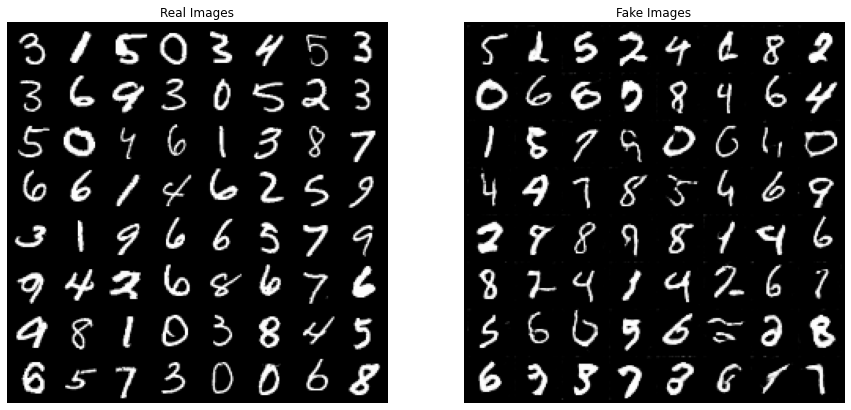

In [93]:
import matplotlib.pyplot as plt

image = plt.imread("/content/saved_images/real_step_379.png")
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(image)

image = plt.imread("/content/saved_images/fake_step_379.png")
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(image)
plt.show()

###### combining

In [50]:
# Batch size during training
batch_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [3]:
rescale = lambda x: 2 * x -1

train_dataset = dset.MNIST(
root = '/content/datasets',
train = True,
transform=transforms.Compose([
                               transforms.ToTensor(),
                               rescale,
                               transforms.Normalize((0.5), (0.5)),
                              ]),
download = True,
)
test_dataset = dset.MNIST(
root = '/content/datasets',
train = False,
transform=transforms.Compose([
                               transforms.ToTensor(),
                               rescale,
                               transforms.Normalize((0.5), (0.5)),
                              ])
)
print(train_dataset)
print(test_dataset)
print(train_dataset.data.size())
print(test_dataset.data.size())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/datasets/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f64537273b0>
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               <function <lambda> at 0x7f64537273b0>
               Normalize(mean=0.5, std=0.5)
           )
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True)

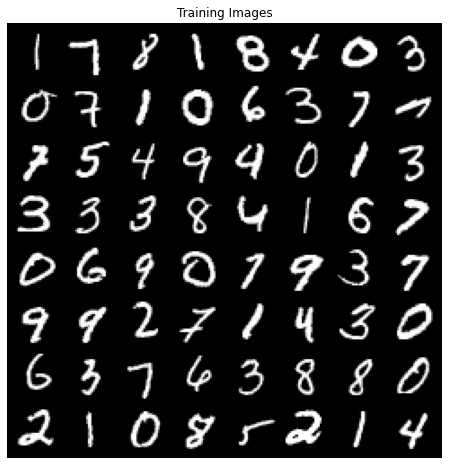

In [12]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [43]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [44]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [45]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 3, bias=False),
            nn.LeakyReLU(0.2),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [46]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [47]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [51]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/938]	Loss_D: 0.0000	Loss_G: 12.5417	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][50/938]	Loss_D: 0.0000	Loss_G: 12.6765	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][100/938]	Loss_D: 0.0000	Loss_G: 12.6992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][150/938]	Loss_D: 0.0000	Loss_G: 12.8213	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][200/938]	Loss_D: 0.0000	Loss_G: 13.1265	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][250/938]	Loss_D: 0.0000	Loss_G: 13.3418	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][300/938]	Loss_D: 0.0000	Loss_G: 13.4525	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][350/938]	Loss_D: 0.0000	Loss_G: 13.5078	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][400/938]	Loss_D: 0.0000	Loss_G: 13.7049	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][450/938]	Loss_D: 0.0000	Loss_G: 13.9252	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][500/938]	Loss_D: 0.0000	Loss_G: 14.0871	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][550/938]	Loss_D: 0.0000	Loss_G: 14.

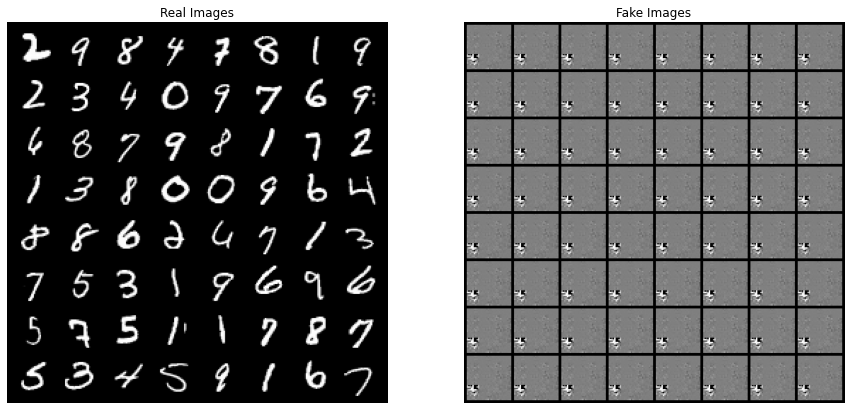

In [52]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()